In [ ]:
import nltk
import pandas as pd
import numpy as np
import re
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

nltk.download('wordent')
nltk.download('popular')
nltk.download('omw-1.4')

[nltk_data] Error loading wordent: Package 'wordent' not found in
[nltk_data]     index
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/

True

# Data Preprocessing

--- Initial Data Head ---
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date Label  
0  December 31, 2017  Fake  
1  December 31, 2017  Fake  
2  December 30, 2017  Fake  
3  December 29, 2017  Fake  
4  December 25, 2017  Fake  
--------------------------------------------------


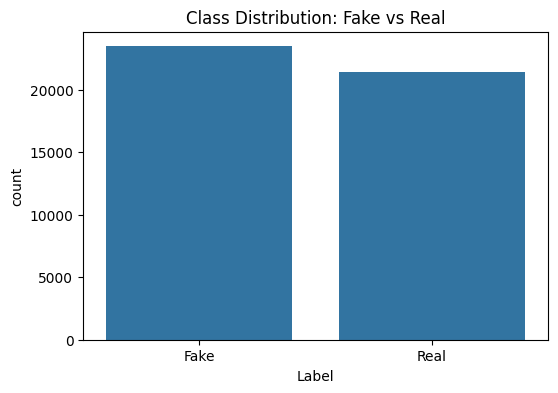


Training Data (X_train) Size: 35918
Testing Data (X_test) Size: 8980


In [ ]:
df_fake = pd.read_csv('../data/Fake.csv')
df_true = pd.read_csv('../data/True.csv')

df_fake['Label'] = 'Fake'
df_true['Label'] = 'Real'
df = pd.concat([df_fake, df_true], ignore_index=True)

print("--- Initial Data Head ---")
print(df.head())
print("-" * 50)

df['title'], df['text'] = df['title'].fillna(''), df['text'].fillna('')
df['Full_Text'] = df['title'] + " " + df['text']
df_cleaned = df[['Full_Text', 'Label']].copy()

df_cleaned['Word_Count'] = df_cleaned['Full_Text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df_cleaned)
plt.title('Class Distribution: Fake vs Real')
plt.show()


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_news_text(text):
    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()

    important_words = []
    for word in words:
        if word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            important_words.append(lemma)

    return " ".join(important_words)


df_cleaned['Final_Clean_Text'] = df_cleaned['Full_Text'].apply(clean_news_text)
X = df_cleaned['Final_Clean_Text']
y = df_cleaned['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining Data (X_train) Size: {len(X_train)}")
print(f"Testing Data (X_test) Size: {len(X_test)}")


# Model building

In [3]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Transform training and testing data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [4]:
model = PassiveAggressiveClassifier(max_iter=50, random_state=42)
model.fit(tfidf_train, y_train)
y_pred = model.predict(tfidf_test)

classes = ['Fake', 'Real']

cm = confusion_matrix(y_test, y_pred, labels=classes)

# Accuracy
print('Model Score: ', model.score(tfidf_test, y_test))
print('Confusion Matrix:\n', cm)
print(classification_report(y_test, y_pred))

Model Score:  0.9938752783964365
Confusion Matrix:
 [[4665   31]
 [  24 4260]]
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



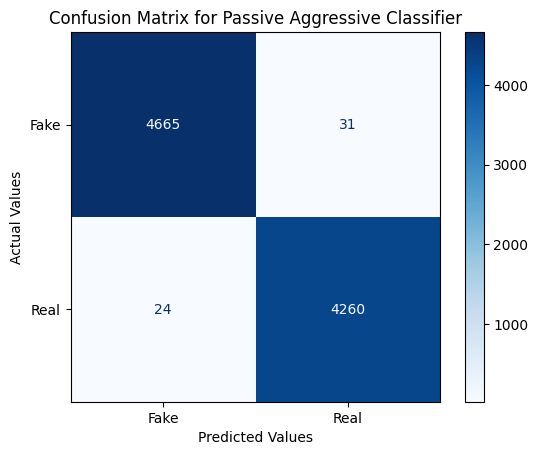

In [5]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Passive Aggressive Classifier')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [6]:
naive_bayes = MultinomialNB()
naive_bayes.fit(tfidf_train, y_train)
naive_pred = naive_bayes.predict(tfidf_test)

naive_confusion = confusion_matrix(y_test, naive_pred, labels=classes)

print('Model Score: ', naive_bayes.score(tfidf_test, y_test))
print('Confusion Matrix:\n', naive_confusion)
print(classification_report(y_test, naive_pred))

Model Score:  0.9310690423162583
Confusion Matrix:
 [[4396  300]
 [ 319 3965]]
              precision    recall  f1-score   support

        Fake       0.93      0.94      0.93      4696
        Real       0.93      0.93      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



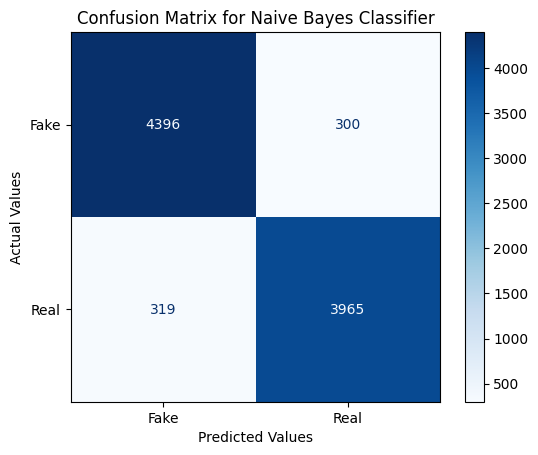

In [7]:
disp1 = ConfusionMatrixDisplay(confusion_matrix= naive_confusion, display_labels= classes)
disp1.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [8]:
svm = LinearSVC()
svm.fit(tfidf_train, y_train)
svm_pred = svm.predict(tfidf_test)

svm_confusion = confusion_matrix(y_test, svm_pred, labels=classes)

print('Model Score: ', svm.score(tfidf_test, y_test))
print('Confusion Matrix:\n', svm_confusion)
print(classification_report(y_test, svm_pred))

Model Score:  0.9944320712694877
Confusion Matrix:
 [[4668   28]
 [  22 4262]]
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      4696
        Real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



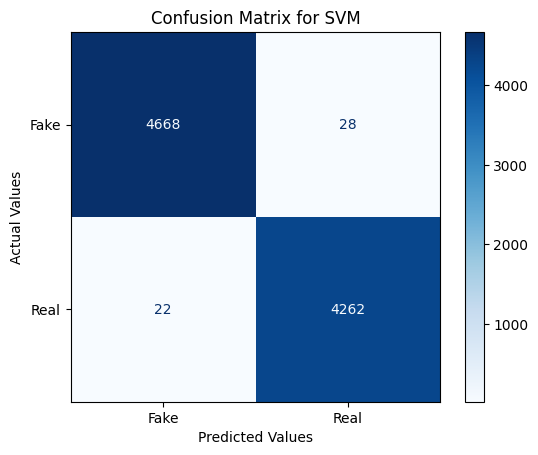

In [9]:
disp2 = ConfusionMatrixDisplay(confusion_matrix= svm_confusion, display_labels= classes)
disp2.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# Evaluation

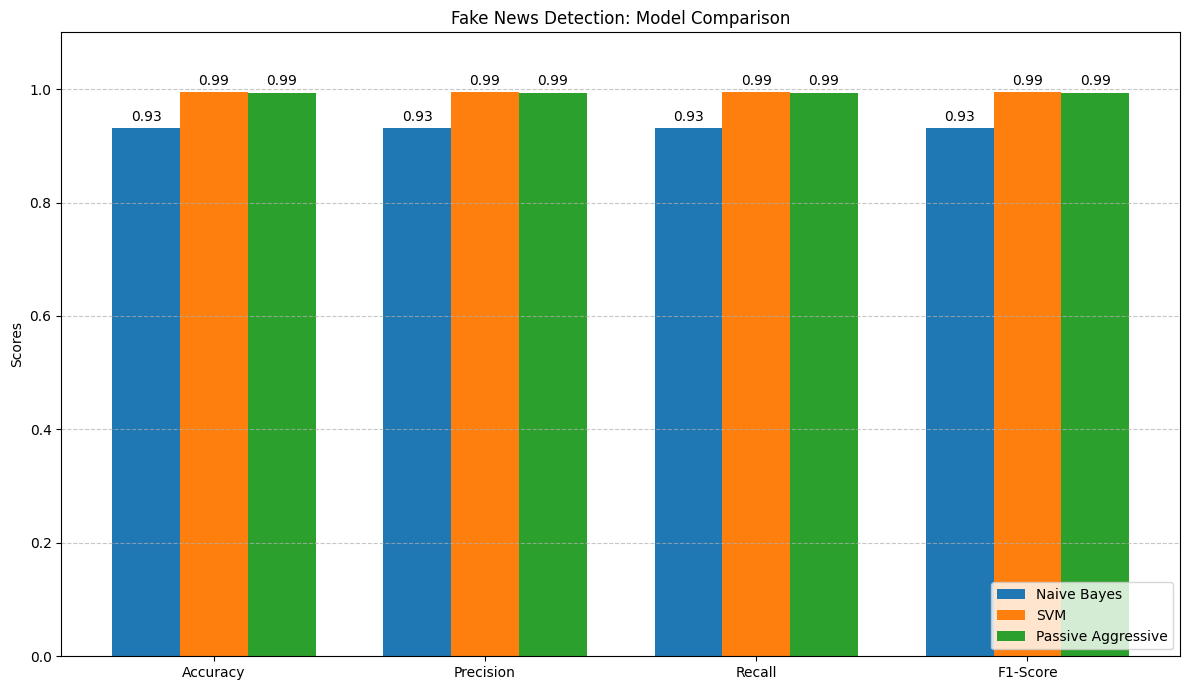

In [10]:
def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

model_results = {
    'Naive Bayes': get_metrics(y_test, naive_pred),
    'SVM': get_metrics(y_test, svm_pred),
    'Passive Aggressive': get_metrics(y_test, y_pred)
}


models = list(model_results.keys())
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))


for i, model_name in enumerate(models):
    scores = [model_results[model_name][m] for m in metrics]
    offset = (i - 1) * width
    rects = ax.bar(x + offset, scores, width, label=model_name)
    ax.bar_label(rects, padding=3, fmt='%.2f')


ax.set_ylabel('Scores')
ax.set_title('Fake News Detection: Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()